In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ffmpeg
from scipy.signal import convolve

In [2]:
filename = "sample.mp4"

probe = ffmpeg.probe(filename)
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])

In [3]:
out, _ = (
    ffmpeg
    .input('sample.mp4')
    .output('pipe:', format='rawvideo', pix_fmt='rgb24', frames=64)
    .run(capture_stdout=True)
)
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

display(f"{video.shape=}")

'video.shape=(64, 1080, 1920, 3)'

'frame.shape=(1080, 1920, 3)'

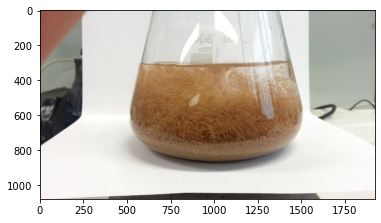

In [4]:
%matplotlib inline
frame = video[0]
display(f"{frame.shape=}")
plt.imshow(frame)

<ipython-input-5-6913ec234926>:10: RuntimeWarning: overflow encountered in ubyte_scalars
  new[y,x] = np.sqrt(  (frame[y, x-1, 0]-frame[y, x, 0])**2
<ipython-input-5-6913ec234926>:11: RuntimeWarning: overflow encountered in ubyte_scalars
  + (frame[y, x-1, 1]-frame[y, x, 1])**2
<ipython-input-5-6913ec234926>:12: RuntimeWarning: overflow encountered in ubyte_scalars
  + (frame[y, x-1, 2]-frame[y, x, 2])**2
<ipython-input-5-6913ec234926>:13: RuntimeWarning: overflow encountered in ubyte_scalars
  + (frame[y, x+1, 0]-frame[y, x, 0])**2
<ipython-input-5-6913ec234926>:14: RuntimeWarning: overflow encountered in ubyte_scalars
  + (frame[y, x+1, 1]-frame[y, x, 1])**2
<ipython-input-5-6913ec234926>:15: RuntimeWarning: overflow encountered in ubyte_scalars
  + (frame[y, x+1, 2]-frame[y, x, 2])**2


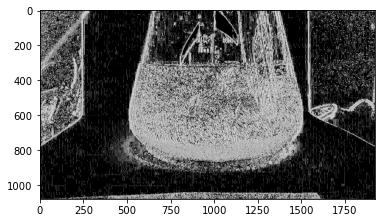

In [5]:
# naive

def energy(frame):
    new = np.zeros(frame.shape[:2], dtype="int32")
    for y in range(frame.shape[0]):
        for x in range(frame.shape[1]):
            if x == 0 or y == 0 or x == frame.shape[1]-1 or y == frame.shape[0]-1:
                new[y,x] = 0
            else:
                new[y,x] = np.sqrt(  (frame[y, x-1, 0]-frame[y, x, 0])**2
                               + (frame[y, x-1, 1]-frame[y, x, 1])**2
                               + (frame[y, x-1, 2]-frame[y, x, 2])**2
                               + (frame[y, x+1, 0]-frame[y, x, 0])**2
                               + (frame[y, x+1, 1]-frame[y, x, 1])**2
                               + (frame[y, x+1, 2]-frame[y, x, 2])**2
                                )
    return new

result_naive = energy(frame)
plt.imshow(result_naive, cmap="Greys_r")

array([[10.,  7.,  3., ...,  0.,  0.,  0.],
       [ 2.,  6.,  3., ...,  0.,  0.,  0.],
       [10.,  3.,  5., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

CPU times: user 146 ms, sys: 9.87 ms, total: 156 ms
Wall time: 155 ms


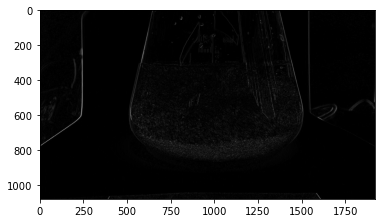

In [6]:
%%time
# kernel convolution on greyscale (averaged channels)

kernel = np.array([[-1, 0, 1]])
E_kernel = np.sqrt(convolve(frame.mean(axis=2), kernel, mode="valid")**2)
display(E_kernel)
plt.imshow(E_kernel, cmap="Greys_r")

CPU times: user 125 ms, sys: 23.2 ms, total: 148 ms
Wall time: 150 ms


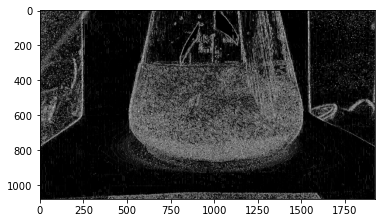

In [7]:
%%time 
# using the formula E = sqrt((lR-mR)² + (lG-mG)² + (lB-mB)² + (rR-rR)² + (rG-rG)² + (rB-rB)²)

l = (np.roll(frame, -1, axis=1) - frame)**2
r = (np.roll(frame,  1, axis=1) - frame)**2

E = np.sqrt((l**2).sum(axis=2) + (r**2).sum(axis=2))
E2 = np.sqrt((l**2+r**2).sum(axis=2))
plt.imshow(E, cmap="Greys_r")



CPU times: user 66.8 ms, sys: 76.2 ms, total: 143 ms
Wall time: 147 ms


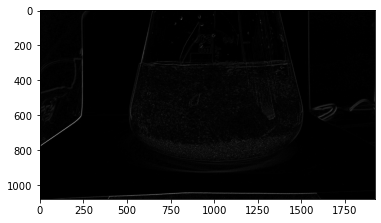

In [8]:
%%time
# gradient map on greyscale (averaged channels)

gradients = np.array(np.gradient(frame.mean(axis=2)))
E_gradient = np.sqrt(gradients.sum(axis=0)**2)

plt.imshow(E_gradient, cmap="Greys_r")


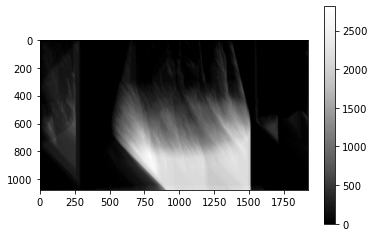

In [9]:
def compute_seams_energies(array):
    seams_energies = np.zeros_like(array)
    for indexes, x in np.ndenumerate(array):
        if indexes[0] == 0:  # top edge
            seams_energies[indexes] = array[indexes]
        elif indexes[1] == 0:  # left edge
            pass
        elif indexes[1] == array.shape[1]-1:  # right edge
            pass
        else:  # anywhere else
            seams_energies[indexes] = min(
                (array[indexes] + seams_energies[indexes[0]-1, indexes[1] - 1]),
                (array[indexes] + seams_energies[indexes[0]-1, indexes[1]]),
                (array[indexes] + seams_energies[indexes[0]-1, indexes[1]])
            )

    return seams_energies


seams_energies = compute_seams_energies(E)
plt.imshow(seams_energies, cmap="Greys_r")
plt.colorbar()